In [ ]:
!pip install imageio

In [ ]:
!pip install --upgrade torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import csv
import json


# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):

    data = {}

    with open(csvFilePath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)

        # Convert each row into a dictionary
        # and add it to data
        for rows in csvReader:
          key = rows['image']
          if key not in data:
            data[key] = {"image": rows['image'],
                         "captions": [rows['caption']]
                        }
          else:
            data[key]["captions"].append(rows['caption'])
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))

In [ ]:
#text_to_json('/content/TRAIN_CAPTIONS.txt','/content/TRAIN_CAPTIONS.json')
make_json('/content/TRAIN_CAPTIONS.txt','/content/TRAIN_CAPTIONS.json')

In [ ]:
import os
import numpy as np
import h5py
import json
import torch
import imageio
from PIL import Image
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from imageio import imread
from skimage.transform import resize as imresize

def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=32):
    assert dataset in {'coco', 'flickr8k', 'flickr30k'}

    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()
    dataset_size = len(data)

    x = 0
    for key in data.keys():
      img = data[key]

      captions = []

      for c in (img['captions']):
        c = c.lower()
        # Update word frequency
        word_freq.update(c.split())
        if len(c.split()) <= max_len:
          captions.append(c)
        if len(captions) == 0:
          captions.append("") # Add an empty caption as a placeholder.

      path = os.path.join(image_folder, img['image'])

      if (x / dataset_size) <= 0.95:
        train_image_paths.append(path)
        train_image_captions.append(captions)
      if (x / dataset_size) > 0.95 and (x / dataset_size) <= 0.98:
        val_image_paths.append(path)
        val_image_captions.append(captions)
      if (x / dataset_size) > 0.98:
        test_image_paths.append(path)
        test_image_captions.append(captions)
      x += 1
    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Create a base/root name for all output files
    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:
           with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:

            h.attrs['captions_per_image'] = captions_per_image

            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):

                # Sample captions
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images

                img = imread(impaths[i])
                if len(img.shape) == 2:
                    img = img[:, :, np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                img = imresize(img, (256, 256))
                img = img.transpose(2, 0, 1)

                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255

                # Save image to HDF5 file
                images[i] = img
                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c.split()] + [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c.split()))
                    # Find caption lengths
                    c_len = len(c.split()) + 2
                    enc_captions.append(enc_c)
                    caplens.append(c_len)
            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)


            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)



In [ ]:
create_input_files(dataset='flickr8k',karpathy_json_path='/content/TRAIN_CAPTIONS.json',image_folder='/content/TRAIN_IMAGES', captions_per_image = 5, min_word_freq = 5, output_folder='/content/output')


Reading TRAIN images and captions, storing to file...



  0%|          | 0/7687 [00:00<?, ?it/s]<ipython-input-3-2e32001a0951>:123: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(impaths[i])
100%|██████████| 7687/7687 [04:28<00:00, 28.64it/s]



Reading VAL images and captions, storing to file...



100%|██████████| 243/243 [00:08<00:00, 28.94it/s]



Reading TEST images and captions, storing to file...



100%|██████████| 161/161 [00:04<00:00, 35.79it/s]


In [ ]:
import os
import numpy as np
import h5py
import json
import torch
#from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_sequence


In [ ]:
import imageio.v3 as iio

# Use Pillow (PIL) for image resizing
def imresize(image_array, size):
    img = Image.fromarray(image_array)
    return np.array(img.resize(size))

In [ ]:
def save_checkpoint(epoch, encoder, decoder, decoder_optimizer):
    state = {'epoch': epoch,
             'encoder': encoder,
             'decoder': decoder,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint' + str(epoch) + '.pth'
    print("=> Saving checkpoint")
    torch.save(state, filename)

class AverageMeter(object):
  def __init__(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


In [ ]:
def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
      param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [ ]:
def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k,1)
    correct = ind.eq(targets.view(-1,1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)


In [ ]:
class Flickr8kDataset(Dataset):
  def __init__(self, data_transforms):
    self.h = h5py.File('/content/output/TRAIN_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', 'r')

    #self.h = h5py.File('TRAIN_IMAGES', 'r')
    self.imgs = self.h['images']
    self.cpi = self.h.attrs['captions_per_image']
    with open('/content/output/TRAIN_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', 'r') as j:
      self.captions = json.load(j)
    with open('/content/output/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', 'r') as j:
      self.caplens = json.load(j)
    self.transform = data_transforms
    self.dataset_size = len(self.captions)

  def __getitem__(self, i):
    img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
    if self.transform is not None:
      img = self.transform(img)
    caption = torch.LongTensor(self.captions[i])
    caplen = torch.LongTensor([self.caplens[i]])
    return img, caption, caplen

  def __len__(self):
    return self.dataset_size

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    resnet = torchvision.models.resnet101(pretrained=True)
    all_modules = list(resnet.children())
    modules = all_modules[:-2]
    self.resnet = nn.Sequential(*modules)
    self.avgpool = nn.AvgPool2d(8)
    self.fine_tune = False

  def fine_tune(self, fine_tune):
    for p in self.resnet.parameters():
      p.requires_grad = fine_tune

  def forward(self, images):
    batch_size = images.shape[0]
    encoded_image = self.resnet(images)
    global_features = self.avgpool(encoded_image).view(batch_size, -1)
    return global_features

In [ ]:
class Decoder(nn.Module):
  def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048):
    super(Decoder, self).__init__()
    self.embed_dim = embed_dim
    self.decoder_dim = decoder_dim
    self.vocab_size = vocab_size
    self.encoder_dim = encoder_dim
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
    self.fc = nn.Linear(decoder_dim, vocab_size)
    self.init_weights()

  def init_weights(self):
   self.embedding.weight.data.uniform_(-0.1, 0.1)
   self.fc.weight.data.uniform_(-0.1, 0.1)
   self.fc.bias.data.fill_(0)

  def init_hidden_states(self, batch_size):
    h = torch.zeros(batch_size, self.decoder_dim).to(device)
    c = torch.zeros(batch_size, self.decoder_dim).to(device)
    return h, c

  def forward(self, global_image, encoded_captions, caption_lengths):
    batch_size = global_image.size(0)
    encoder_dim = global_image.size(-1)

    # Check if caption_lengths requires squeezing
    caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
    global_image = global_image[sort_ind]
    encoded_captions = encoded_captions[sort_ind]

    # Pad encoded captions to the same length
    #encoded_captions = pad_sequence(encoded_captions, batch_first=True, padding_value=0)  # Pad with zeros

    embeddings = self.embedding(encoded_captions)
    h, c = self.init_hidden_states(batch_size)
    decode_lengths = (caption_lengths - 1).tolist()
    predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device)

    for t in range(max(decode_lengths)):
      batch_size_t = sum([l > t for l in decode_lengths])
      lstm_input = torch.cat([embeddings[:batch_size_t, t, :], global_image[:batch_size_t]], dim=-1)
      h, c = self.lstm(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
      preds = self.fc(h)
      predictions[:batch_size_t, t, :] = preds

    return predictions, encoded_captions, decode_lengths, sort_ind

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
def train(train_loader, encoder, decoder, criterion, decoder_optimizer, epoch):
  encoder.train()
  decoder.train()
  losses = AverageMeter()
  top3accs = AverageMeter()

  for i, (img, caption, caplen) in enumerate(train_loader):
    img = img.to(device)
    caption = caption.to(device)
    caplen = caplen.to(device)

    global_features = encoder(img)
    scores, caps_sorted, decode_lengths, sort_ind = decoder(global_features, caption, caplen)
    targets = caps_sorted[:, 1:]

    # Pack padded sequences
    scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
    targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
    loss = criterion(scores.data, targets.data)
    decoder_optimizer.zero_grad()
    loss.backward()
    decoder_optimizer.step()

    top3 = accuracy(scores.data, targets.data, 3)
    losses.update(loss.item(),sum(decode_lengths))
    top3accs.update(top3, sum(decode_lengths))

    if i % print_freq == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            'Top3Acc {top3.val:.3f} ({top3.avg:.3f})'.format(epoch, i, len(train_loader),
                                                         loss=losses, top3=top3accs))

In [49]:
from typing_extensions import reveal_type
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim = 512
decoder_dim = 512
decoder_lr = 5e-4
start_epoch = 0
epochs = 100
batch_size = 60
print_freq = 100
#checkpoint = None
checkpoint = '/content/checkpoint49.pth'


with open('/content/output/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json', 'r') as j:
  wordmap = json.load(j)

rev_wordmap = {v: k for k, v in wordmap.items()}
if checkpoint is None:
  encoder = Encoder()
  decoder = Decoder(embed_dim = emb_dim, decoder_dim = decoder_dim, vocab_size = len(wordmap))
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_lr)
else:
  checkpoint = torch.load(checkpoint)
  start_epoch = checkpoint['epoch'] + 1
  decoder = checkpoint['decoder']
  decoder_optimizer = checkpoint['decoder_optimizer']
  encoder = checkpoint['encoder']

encoder = encoder.to(device)
decoder = decoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])

train_loader = torch.utils.data.DataLoader(Flickr8kDataset(transform),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True)

In [50]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from imageio import imread
from PIL import Image
import numpy as np
from skimage.transform import resize

def process_image(image):
    img = imread(image)
    plt.imshow(img)
    img = resize(img, (256, 256)) # (256,256,3)
    img = img.transpose(2, 0, 1) # channels first
    img = img / 255
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    img = transform(img) # (3, 256, 256)
    return img

def greedy_decode(image):
  decoder.eval()
  encoder.eval()
  max_len = 20
  sampled = []
  rev_wordmap = {v: k for k, v in wordmap.items()}

  img = process_image(image)
  img = img.unsqueeze(0)
  global_features = encoder(img)

  pred = torch.LongTensor([[wordmap['<start>']]]).to(device)
  h, c = decoder.init_hidden_states(1)

  for timestep in range(max_len):
    embeddings = decoder.embedding(pred).squeeze(1)
    lstm_input = torch.cat([embeddings, global_features], dim=1)
    h, c = decoder.lstm(lstm_input, (h, c))
    preds = decoder.fc(h)
    _, pred = preds.max(1)

    sampled.append(pred.item())

    if pred == wordmap['<end>']:
      break

  # Handle the case where the predicted index is not in the vocabulary
  generated_words = [rev_wordmap[sampled[i]] for i in range(len(sampled))]
  filtered_words = ' '.join([word for word in generated_words if word!='<end>'])

  print(filtered_words)

In [ ]:
for epoch in range(start_epoch, epochs):
  if epoch % 3 == 0 and epoch != 0:
    adjust_learning_rate(decoder_optimizer, 0.8)
  train(train_loader, encoder=encoder, decoder=decoder, criterion=criterion, decoder_optimizer=decoder_optimizer, epoch=epoch)
  save_checkpoint(epoch, encoder, decoder, decoder_optimizer)
greedy_decode('/content/TRAIN_IMAGES/12830823_87d2654e31.jpg')

Epoch: [50][0/641]	Loss 2.3806 (2.3806)	Top3Acc 63.464 (63.464)
Epoch: [50][100/641]	Loss 2.3845 (2.3590)	Top3Acc 64.807 (64.200)
Epoch: [50][200/641]	Loss 2.3433 (2.3507)	Top3Acc 63.079 (64.402)
Epoch: [50][300/641]	Loss 2.3540 (2.3539)	Top3Acc 63.811 (64.375)
Epoch: [50][400/641]	Loss 2.4380 (2.3539)	Top3Acc 64.189 (64.366)
Epoch: [50][500/641]	Loss 2.2831 (2.3572)	Top3Acc 66.533 (64.333)
Epoch: [50][600/641]	Loss 2.3325 (2.3586)	Top3Acc 65.173 (64.314)
=> Saving checkpoint

DECAYING learning rate.
The new learning rate is 0.000011

Epoch: [51][0/641]	Loss 2.3442 (2.3442)	Top3Acc 63.980 (63.980)
Epoch: [51][100/641]	Loss 2.3469 (2.3479)	Top3Acc 65.870 (64.365)
Epoch: [51][200/641]	Loss 2.4763 (2.3493)	Top3Acc 63.698 (64.341)
Epoch: [51][300/641]	Loss 2.4140 (2.3518)	Top3Acc 61.840 (64.307)
Epoch: [51][400/641]	Loss 2.3326 (2.3544)	Top3Acc 64.391 (64.298)
Epoch: [51][500/641]	Loss 2.4948 (2.3568)	Top3Acc 63.553 (64.297)
Epoch: [51][600/641]	Loss 2.4469 (2.3563)	Top3Acc 60.274 (64.317)

<ipython-input-43-1f36c93e26fc>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(image)


a young girl is playing on a beach .


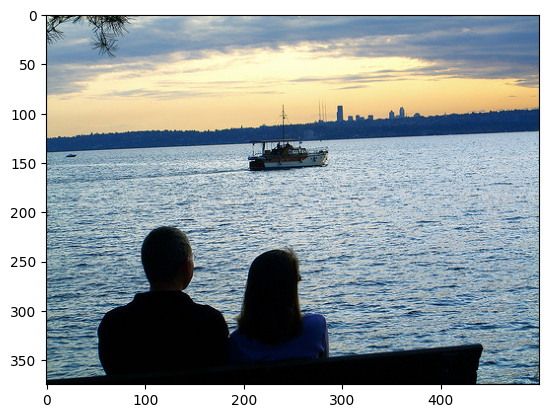

In [45]:
greedy_decode('/content/TRAIN_IMAGES/44129946_9eeb385d77.jpg')

<ipython-input-43-1f36c93e26fc>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(image)


a woman wearing a red jacket and a white helmet and red jacket and a black jacket and a black


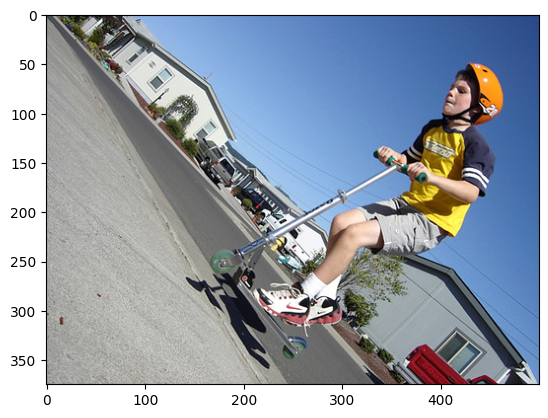

In [46]:
greedy_decode('/content/TRAIN_IMAGES/47870024_73a4481f7d.jpg')

<ipython-input-43-1f36c93e26fc>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(image)


a young girl is playing with a ball in the pool .


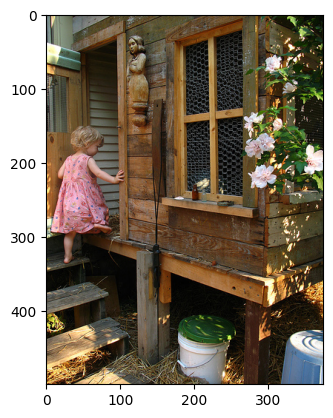

In [47]:
greedy_decode('/content/TRAIN_IMAGES/1000268201_693b08cb0e.jpg')

<ipython-input-37-1f36c93e26fc>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(image)


a man is standing on a rock overlooking a river .


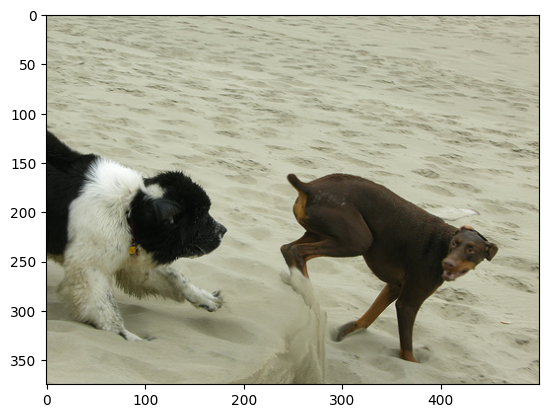

In [ ]:
greedy_decode('/content/TRAIN_IMAGES/1067790824_f3cc97239b.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive

ls: cannot access '/content/gdrive/My Drive': No such file or directory


In [ ]:
!cp -r /content/TRAIN_IMAGES /content/gdrive/My\ Drive/DL_Images


In [ ]:
!cp -r /content/gdrive/My\ Drive/DL_Images/TRAIN_IMAGES /content/